# Imports

In [44]:
#imports

import matplotlib.pyplot as plt
import seaborn
import seaborn as sb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import numpy as np

import torchvision
import torchvision.transforms as transforms

from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm
import pandas as pd

import NoiseFactory as NF
import TransformationFactory as TF
from resnet20 import ResNetCIFAR

import test_dataset as test_ds

# 1. Resnet-20 Class & Instantiation Functions

In [45]:
def instantiate_ResNet_model():
    # specify the device for computation
    #############################################
    # your code here
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device =='cuda':
        print("Run on GPU...")
    else:
        print("Run on CPU...")

    # Model Definition
    net = ResNetCIFAR(num_layers=20, Nbits=None) # from HW 4
    net = net.to(device)
    #############################################
    return net, device

In [46]:
def set_up_loss_function(device,
                         net,
                         INITIAL_LR: float=0.01,
                         MOMENTUM: float=0.9,
                         regularization_method: str="L2",
                         REG: float=0.0001):
    # hyperparameters, do NOT change right now
    # initial learning rate
    INITIAL_LR = INITIAL_LR

    # momentum for optimizer
    MOMENTUM = MOMENTUM

    regularization_method = regularization_method
    # L2 regularization strength
    REG = REG                  # <--- used to control both L2 and L1 regularization methods

    #############################################
    # your code here
    # create loss function
    # add L1 regularization here.
    criterion = nn.CrossEntropyLoss().to(device)

    # Add optimizer
    if regularization_method == "L2":
        optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
    else:
        optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM)
    #############################################

    return criterion, optimizer

# 2. Data Transformation and Data Loader Functions

In [47]:
def get_training_transforms(intensity:int=0, noise = None, p:float=0.5):
    if intensity is None:
        intensity = 0

    n_factory = NF.NoiseFactory()
    transforms_factory = TF.TransformationFactory()

    transform_train = transforms_factory.get_transformation_composition_by_name(transformation_set=noise, intensity=intensity, p=p, train_test_validation='train')
    noise_factory_function = n_factory.get_noise_by_name(noise_type_name=noise, intensity=intensity, p=p)
    transform_val =transforms_factory.get_transformation_composition_by_name(transformation_set=None, p=p, train_test_validation='val')

    return transform_train, transform_val, noise_factory_function

In [48]:
def build_train_validation_sets(TRAIN_BATCH_SIZE: int =128,
                                VAL_BATCH_SIZE: int = 100,
                                training_noise_type: str = None,
                                training_noise_type_intensity: int = None,
                                probability_of_being_applied: float = 0.5):

    # set transformations
    transform_train, transform_val, noise_factory_function = get_training_transforms(noise=training_noise_type,
                                                                                     intensity=training_noise_type_intensity,
                                                                                     p=probability_of_being_applied)

    # a few arguments, do NOT change these
    DATA_ROOT = "./data"
    TRAIN_BATCH_SIZE = TRAIN_BATCH_SIZE
    VAL_BATCH_SIZE = VAL_BATCH_SIZE

    #############################################
    # your code here
    # construct dataset
    train_set = test_ds.CIFAR10(root='./data', train=True, download=True, transform=transform_train, imgaug_types=noise_factory_function)
    # train_set = CIFAR10(
    #     root=DATA_ROOT,
    #     mode='train',
    #     download=True,
    #     transform=transform_train,    # your code
    #     imgaug_types=noise_factory_function
    # )
    val_set = CIFAR10(
        root=DATA_ROOT,
        mode='val',
        download=True,
        transform=transform_val    # your code
    )

    # construct dataloader
    train_loader = DataLoader(
        train_set,
        batch_size=TRAIN_BATCH_SIZE ,  # your code
        shuffle=True,     # your code
        num_workers=4
    )
    val_loader = DataLoader(
        val_set,
        batch_size=VAL_BATCH_SIZE,  # your code
        shuffle=True,     # your code, shuffle to increase the random order the images are presented to prevent the model from experinceing cycles (which will make it harder to converge)
        num_workers=4
    )
    #############################################

    return train_set, val_set, train_loader, val_loader

# 3. Train/Validation function

In [49]:
def resnet_train_model(TRAIN_BATCH_SIZE: int = 128, # agnostic to transformations
                       VAL_BATCH_SIZE: int = 100,
                       training_noise_type: str = None,
                       training_noise_type_intensity: int = 0,
                       probability_of_being_applied: float = 0.5,
                       training_epochs: int = 200,
                       model_name: str = "NO_NOISE_MODEL.pt",
                       INITIAL_LR: float = 0.01,
                       MOMENTUM: float = 0.9,
                       regularization_method: str = "L2",
                       REG: float = 0.0001
                       ):

    # 2. Build/load training/validation data sets
    #    This injects noise into the training data set
    train_set, val_set, train_loader, val_loader = build_train_validation_sets(TRAIN_BATCH_SIZE=TRAIN_BATCH_SIZE,
                                                                               VAL_BATCH_SIZE=VAL_BATCH_SIZE,
                                                                               training_noise_type=training_noise_type,
                                                                               training_noise_type_intensity=training_noise_type_intensity,
                                                                               probability_of_being_applied = probability_of_being_applied)

    # 3.A. instantiate model, and put it on a GPU if a GPU is available
    net, device = instantiate_ResNet_model()

    # 3.B. set-up criterion, and optimizer
    criterion, optimizer = set_up_loss_function(device=device,
                                                net = net,
                                                INITIAL_LR=INITIAL_LR,
                                                MOMENTUM=MOMENTUM,
                                                regularization_method=regularization_method,
                                                REG=REG)

    # the folder where the trained model is saved
    CHECKPOINT_FOLDER = "./saved_models"

    #
    # Code to train the model goes here
    #      All code from a training block in HW2/HW5 would go here
    current_lr = INITIAL_LR
    best_validation_acc = 0
    print("==> Training starts!")
    print("="*50)
    vald_acc = []
    lr_reset_min = 20
    initial_lr = True
    vald_loss = []

    for i in range(0, training_epochs):
        # handle the learning rate scheduler.
        lr_reset_min -= 1
        if lr_reset_min<=0:
            if initial_lr:
                current_lr=0.1
                lr_reset_min = 40
                initial_lr = False
                for param_group in optimizer.param_groups:
                    param_group['lr'] = current_lr
                    print("Current learning rate has decayed to %f" %current_lr)
            elif abs(vald_acc[i-1] - np.mean(vald_acc[i-9:i]))*100 < 5:
                current_lr = current_lr * 0.1
                lr_reset_min = 60
                for param_group in optimizer.param_groups:
                    param_group['lr'] = current_lr
                    print("Current learning rate has decayed to %f" %current_lr)
        ######################
        # switch to train mode
        net.train()
        ######################
        print("Epoch %d:" %i)
        total_examples = 0 # this helps you compute the training accuracy
        correct_examples = 0
        train_loss = 0 # track training loss if you want

        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader): # this might really need to be changed over to something new
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            # loss = criterion(outputs, targets)
            if regularization_method == "L1":
                L1_sum = 0.0
                for name, module in net.named_modules():
                    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                        L1_sum = L1_sum + torch.sum(torch.abs(module.weight))
                loss = criterion(outputs, targets) + REG * L1_sum
            else:
                loss = criterion(outputs, targets)

            # zero the gradient
            optimizer.zero_grad()

            # backpropagation
            loss.backward()

            # apply gradient and update the weights
            optimizer.step()

            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            total_examples += targets.shape[0]
            train_loss  += loss
            correct_examples += correct.item()
            ####################################

        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

        # ######################
        # # switch to val mode
        # net.eval()
        # ######################
        # total_examples = 0
        # correct_examples = 0
        #
        # val_loss = 0 # again, track the validation loss if you want
        #
        # # disable gradient during validation, which can save GPU memory
        # with torch.no_grad():
        #     for batch_idx, (inputs, targets) in enumerate(val_loader):
        #         ####################################
        #         # your code here
        #         # copy inputs to device
        #         inputs = inputs.to(device)
        #         targets = targets.to(device)
        #
        #         # compute the output and loss
        #         outputs = net(inputs)
        #         loss = criterion(outputs, targets)
        #
        #         # count the number of correctly predicted samples in the current batch
        #         _, predicted = torch.max(outputs, 1)
        #         correct = predicted.eq(targets).sum()
        #         total_examples += targets.shape[0]
        #         val_loss  += loss
        #         correct_examples += correct.item()
        #         ####################################

        # avg_loss = val_loss / len(val_loader)
        # avg_acc = correct_examples / total_examples
        # print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        vald_acc.append(avg_acc)
        vald_loss.append(float(avg_loss))

        # Make sure to save the best model checkpoint for this noise type
        if avg_acc > best_validation_acc:
            best_validation_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': net.state_dict(),
                     'epoch': i,
                     'lr': current_lr}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, model_name))

    #training time data
    training_time_file_name = CHECKPOINT_FOLDER + '/' + model_name + '_training_time_data.csv'
    valdation_df = list(zip(vald_loss, vald_acc))
    df = pd.DataFrame(valdation_df, columns = ['Loss', 'Accuracy'])
    df.to_csv(path_or_buf=training_time_file_name, sep=',',)

In [50]:
noise_type = ["gaussian-blur", "scale", "salt", "salt", "motion-blur", "random-perspective", "coarse-pepper", "coarse-pepper", "coarse-pepper"]
intensity =  [ 5, 2, 3, 4, 5, 2, 2, 5, 3 ]
frequency =  [0.8, 0.9, 0.2, 0.4, 0.5, 0.4, 1.0, 0.8, 0.6]
model_name = ["DoE1_model_1.pth", "DoE1_model_2.pth", "DoE1_model_3.pth", "DoE1_model_4.pth", "DoE1_model_5.pth", "DoE1_model_6.pth", "DoE1_model_7.pth", "DoE1_model_8.pth", "DoE1_model_9.pth" ]
for i in range (0, len(noise_type)):
    resnet_train_model(
        training_noise_type = noise_type[i],
        training_noise_type_intensity = intensity[i],
        probability_of_being_applied= frequency[i],
        model_name = model_name[i], training_epochs=200)

/home/taylor/Duke/ECE661/projects/untitled/final_project/NoiseFactory.py:48: UserWarning: NoiseFactory not supplied with an expected name, so noNoise supplied.
  warnings.warn("NoiseFactory not supplied with an expected name, so noNoise supplied.")
/home/taylor/Duke/ECE661/projects/untitled/final_project/TransformationFactory.py:140: UserWarning: TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.
  warnings.warn("TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.")


Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Run on GPU...
==> Training starts!
Epoch 0:
Training loss: 1.7519, Training accuracy: 0.3546
Saving ...
Epoch 1:
Training loss: 1.4850, Training accuracy: 0.4613
Saving ...
Epoch 2:
Training loss: 1.3642, Training accuracy: 0.5069
Saving ...
Epoch 3:
Training loss: 1.2641, Training accuracy: 0.5463
Saving ...
Epoch 4:
Training loss: 1.1799, Training accuracy: 0.5761
Saving ...
Epoch 5:
Training loss: 1.1110, Training accuracy: 0.6035
Saving ...
Epoch 6:
Training loss: 1.0523, Training accuracy: 0.6274
Saving ...
Epoch 7:
Training loss: 1.0029, Training accuracy: 0.6473
Saving ...
Epoch 8:
Training loss: 0.9505, Training accuracy: 0.6647
Saving ...
Epoch 9:
Training loss: 0.9153, Training accuracy: 0.6780
Saving ...
Epoch 10:
Training loss: 0.8807, Training accuracy: 0.6917
Saving ...
Epoch 11

KeyboardInterrupt: 

# 4. Test Function

In [ ]:
def get_test_transforms(intensity:int=0, noise = None, p:float=0.5):
    if intensity is None:
        intensity = 0

    n_factory = NF.NoiseFactory()
    transforms_factory = TF.TransformationFactory()

    transform_test = transforms_factory.get_transformation_composition_by_name(transformation_set=noise, intensity=intensity, p=p, train_test_validation='test')
    noise_factory_function = n_factory.get_noise_by_name(noise_type_name=noise, intensity=intensity, p=p)

    return transform_test, noise_factory_function

In [ ]:
def get_test_data(test_noise_transformation: str = None,
                  test_noise_transformation_intensity: int = None):
    DATA_ROOT = "./data"
    transform_test, noise_factory_function = get_test_transforms(intensity=test_noise_transformation_intensity, noise = test_noise_transformation, p=1.0)
    test_set = CIFAR10(
        root=DATA_ROOT,
        mode='test',
        download=True,
        transform=transform_test,
        imgaug_types=noise_factory_function
    )

    return test_set

In [ ]:
def test(net,
         test_noise_transformation: str = None,
         test_noise_transformation_intensity: int = None,):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # transform_test = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #
    # ])

    transform_test, noise_factory_function = get_test_transforms(intensity=test_noise_transformation_intensity, noise = test_noise_transformation, p=1.0)
    testset = test_ds.CIFAR10(root='./data', train=False, download=True, transform=transform_test, imgaug_types=noise_factory_function)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = nn.CrossEntropyLoss()

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return val_acc

In [ ]:
def test_function(model_to_test: str = 'resnet',
                  BATCH_SIZE:int = 100,
                  test_noise_transformation: str = None,
                  test_noise_transformation_intensity: int = None,
                  ):

    net = ResNetCIFAR()
    checkpoint = torch.load(f'./saved_models/{model_to_test}') # change the path to your own checkpoint file
    net.load_state_dict(checkpoint['state_dict'])
    net.cuda()

    acc = test(net, test_noise_transformation, test_noise_transformation_intensity)
    return acc # this should be a single accuracy number

In [ ]:
def run_testing(model=None):
    # net, device = instantiate_ResNet_model()
    if model is None:
        list_of_model_names = ["base_model.pth", "DoE1_model_1.pth", "DoE1_model_2.pth", "DoE1_model_3.pth", "DoE1_model_4.pth", "DoE1_model_5.pth", "DoE1_model_6.pth", "DoE1_model_7.pth", "DoE1_model_8.pth", "DoE1_model_9.pth"]
                           #"DoE1_model_10.pth", "DoE1_model_11.pth", "DoE1_model_12.pth", "DoE1_model_13.pth", "DoE1_model_14.pth", "DoE1_model_15.pth", "DoE1_model_16.pth", "DoE1_model_17.pth"]
    else:
        list_of_model_names = [model]
    adversarial_noises = ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop",  "random-perspective"]
    intensity_levels = [1, 2, 3, 4, 5]
    models_dict = {}

    #
    # This loop creates a dictionary of dictionaries that contains lists (i.e. the outer most dictionary contains entries for each model, and each of those entries is it self a dictionary that contsin entries for each adversarial noise type. Each adversarial noise type entry is a list, and those lists contain the accuracy results of the test in order from least intense to most intense)
    #
    for model in list_of_model_names:
        noises_dict = {}
        for noise_type in adversarial_noises:
            results = []
            for intensity_level in intensity_levels:
                result = test_function(model_to_test = model,
                                       BATCH_SIZE = 100,
                                       test_noise_transformation=noise_type,
                                       test_noise_transformation_intensity=intensity_level)
                results.append(result)
            noises_dict[noise_type] = results
        models_dict[model] = noises_dict
    print(models_dict)
    return models_dict

In [51]:
model_1_results = run_testing("DoE1_model_1.pth")

/home/taylor/Duke/ECE661/projects/untitled/final_project/TransformationFactory.py:140: UserWarning: TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.
  warnings.warn("TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.")


Files already downloaded and verified
Test Loss=0.4134, Test accuracy=0.8751
Files already downloaded and verified
Test Loss=0.4997, Test accuracy=0.8505
Files already downloaded and verified
Test Loss=1.1679, Test accuracy=0.6932
Files already downloaded and verified
Test Loss=3.9436, Test accuracy=0.3656
Files already downloaded and verified
Test Loss=11.4758, Test accuracy=0.1745
Files already downloaded and verified
Test Loss=84.6996, Test accuracy=0.0996
Files already downloaded and verified
Test Loss=106.4520, Test accuracy=0.0985
Files already downloaded and verified
Test Loss=136.5179, Test accuracy=0.1002
Files already downloaded and verified
Test Loss=156.8220, Test accuracy=0.0998
Files already downloaded and verified
Test Loss=171.9716, Test accuracy=0.0999


/home/taylor/Duke/ECE661/projects/untitled/final_project/NoiseFactory.py:48: UserWarning: NoiseFactory not supplied with an expected name, so noNoise supplied.
  warnings.warn("NoiseFactory not supplied with an expected name, so noNoise supplied.")


Files already downloaded and verified
Test Loss=0.6495, Test accuracy=0.8083
Files already downloaded and verified
Test Loss=0.8927, Test accuracy=0.7470
Files already downloaded and verified
Test Loss=0.9959, Test accuracy=0.7338
Files already downloaded and verified
Test Loss=0.6234, Test accuracy=0.8220
Files already downloaded and verified
Test Loss=0.4636, Test accuracy=0.8589
Files already downloaded and verified
Test Loss=0.4134, Test accuracy=0.8752
Files already downloaded and verified
Test Loss=0.4134, Test accuracy=0.8752
Files already downloaded and verified
Test Loss=0.4134, Test accuracy=0.8752
Files already downloaded and verified
Test Loss=0.4134, Test accuracy=0.8752
Files already downloaded and verified
Test Loss=0.4134, Test accuracy=0.8752
Files already downloaded and verified
Test Loss=21.6971, Test accuracy=0.2900
Files already downloaded and verified
Test Loss=34.3152, Test accuracy=0.1601
Files already downloaded and verified
Test Loss=47.2285, Test accuracy=0.1

In [52]:
model_2_results = run_testing("DoE1_model_2.pth")

/home/taylor/Duke/ECE661/projects/untitled/final_project/TransformationFactory.py:140: UserWarning: TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.
  warnings.warn("TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.")


Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9093
Files already downloaded and verified
Test Loss=0.4029, Test accuracy=0.9103
Files already downloaded and verified
Test Loss=0.5692, Test accuracy=0.8776
Files already downloaded and verified
Test Loss=1.8285, Test accuracy=0.6520
Files already downloaded and verified
Test Loss=7.0862, Test accuracy=0.2393
Files already downloaded and verified
Test Loss=255.5030, Test accuracy=0.1001
Files already downloaded and verified
Test Loss=331.4645, Test accuracy=0.1000
Files already downloaded and verified
Test Loss=403.0071, Test accuracy=0.1000
Files already downloaded and verified
Test Loss=450.2525, Test accuracy=0.1000
Files already downloaded and verified
Test Loss=478.5571, Test accuracy=0.1000


/home/taylor/Duke/ECE661/projects/untitled/final_project/NoiseFactory.py:48: UserWarning: NoiseFactory not supplied with an expected name, so noNoise supplied.
  warnings.warn("NoiseFactory not supplied with an expected name, so noNoise supplied.")


Files already downloaded and verified
Test Loss=3.1041, Test accuracy=0.5110
Files already downloaded and verified
Test Loss=5.7258, Test accuracy=0.2655
Files already downloaded and verified
Test Loss=6.1543, Test accuracy=0.2080
Files already downloaded and verified
Test Loss=6.1086, Test accuracy=0.1879
Files already downloaded and verified
Test Loss=5.9118, Test accuracy=0.1778
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and verified
Test Loss=21.4140, Test accuracy=0.3188
Files already downloaded and verified
Test Loss=38.0567, Test accuracy=0.1697
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6ad04459d0>
Traceback (most recent call last):
  File "/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test Loss=68.0036, Test accuracy=0.1103
Files already downloaded and verified
Test Loss=94.8101, Test accuracy=0.1021
Files already downloaded and verified
Test Loss=118.3947, Test accuracy=0.1001
Files already downloaded and verified
Test Loss=0.9760, Test accuracy=0.7998
Files already downloaded and verified
Test Loss=2.1213, Test accuracy=0.5876
Files already downloaded and verified
Test Loss=3.0420, Test accuracy=0.4143
Files already downloaded and verified
Test Loss=3.6087, Test accuracy=0.3178
Files already downloaded and verified
Test Loss=3.9086, Test accuracy=0.2585
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and verified
Test Loss=0.4004, Test accuracy=0.9092
Files already downloaded and veri

In [53]:
model_3_results = run_testing("DoE1_model_3.pth")

Files already downloaded and verified
Test Loss=0.3446, Test accuracy=0.9050
Files already downloaded and verified
Test Loss=0.4372, Test accuracy=0.8777
Files already downloaded and verified
Test Loss=1.3675, Test accuracy=0.6385
Files already downloaded and verified
Test Loss=3.9288, Test accuracy=0.2818
Files already downloaded and verified
Test Loss=11.4290, Test accuracy=0.1403
Files already downloaded and verified
Test Loss=0.3778, Test accuracy=0.8889
Files already downloaded and verified
Test Loss=0.4055, Test accuracy=0.8820
Files already downloaded and verified
Test Loss=0.4508, Test accuracy=0.8642
Files already downloaded and verified
Test Loss=0.5361, Test accuracy=0.8370
Files already downloaded and verified
Test Loss=0.6652, Test accuracy=0.7917
Files already downloaded and verified
Test Loss=2.3084, Test accuracy=0.6008
Files already downloaded and verified
Test Loss=4.9589, Test accuracy=0.3513
Files already downloaded and verified
Test Loss=5.7058, Test accuracy=0.276

In [54]:
model_4_results = run_testing("DoE1_model_4.pth")

Files already downloaded and verified
Test Loss=0.4056, Test accuracy=0.8804
Files already downloaded and verified
Test Loss=0.5341, Test accuracy=0.8441
Files already downloaded and verified
Test Loss=1.7196, Test accuracy=0.5314
Files already downloaded and verified
Test Loss=4.5524, Test accuracy=0.1734
Files already downloaded and verified
Test Loss=6.1524, Test accuracy=0.1180
Files already downloaded and verified
Test Loss=0.4187, Test accuracy=0.8774
Files already downloaded and verified
Test Loss=0.4297, Test accuracy=0.8711
Files already downloaded and verified
Test Loss=0.4502, Test accuracy=0.8687
Files already downloaded and verified
Test Loss=0.4804, Test accuracy=0.8577
Files already downloaded and verified
Test Loss=0.5338, Test accuracy=0.8414
Files already downloaded and verified
Test Loss=1.4925, Test accuracy=0.6693
Files already downloaded and verified
Test Loss=3.1115, Test accuracy=0.4423
Files already downloaded and verified
Test Loss=3.8441, Test accuracy=0.3444

In [55]:
model_5_results = run_testing("DoE1_model_5.pth")

/home/taylor/Duke/ECE661/projects/untitled/final_project/TransformationFactory.py:140: UserWarning: TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.
  warnings.warn("TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.")


Files already downloaded and verified
Test Loss=0.3462, Test accuracy=0.9038
Files already downloaded and verified
Test Loss=0.4825, Test accuracy=0.8595
Files already downloaded and verified
Test Loss=2.4185, Test accuracy=0.4282
Files already downloaded and verified
Test Loss=7.6354, Test accuracy=0.1477
Files already downloaded and verified
Test Loss=18.5857, Test accuracy=0.1041
Files already downloaded and verified
Test Loss=55.6962, Test accuracy=0.1016
Files already downloaded and verified
Test Loss=59.0296, Test accuracy=0.1026
Files already downloaded and verified
Test Loss=82.1556, Test accuracy=0.1020
Files already downloaded and verified
Test Loss=94.8565, Test accuracy=0.0988
Files already downloaded and verified
Test Loss=99.1862, Test accuracy=0.1001


/home/taylor/Duke/ECE661/projects/untitled/final_project/NoiseFactory.py:48: UserWarning: NoiseFactory not supplied with an expected name, so noNoise supplied.
  warnings.warn("NoiseFactory not supplied with an expected name, so noNoise supplied.")


Files already downloaded and verified
Test Loss=1.8823, Test accuracy=0.6056
Files already downloaded and verified
Test Loss=3.8563, Test accuracy=0.3696
Files already downloaded and verified
Test Loss=4.4467, Test accuracy=0.3025
Files already downloaded and verified
Test Loss=4.6575, Test accuracy=0.2763
Files already downloaded and verified
Test Loss=4.7251, Test accuracy=0.2565
Files already downloaded and verified
Test Loss=0.3462, Test accuracy=0.9038
Files already downloaded and verified
Test Loss=0.3462, Test accuracy=0.9038
Files already downloaded and verified
Test Loss=0.3462, Test accuracy=0.9038
Files already downloaded and verified
Test Loss=0.3462, Test accuracy=0.9038
Files already downloaded and verified
Test Loss=0.3462, Test accuracy=0.9038
Files already downloaded and verified
Test Loss=11.7224, Test accuracy=0.3411
Files already downloaded and verified
Test Loss=19.0643, Test accuracy=0.1828
Files already downloaded and verified
Test Loss=26.2090, Test accuracy=0.1

In [56]:
model_6_results = run_testing("DoE1_model_6.pth")

Files already downloaded and verified
Test Loss=0.3004, Test accuracy=0.9211
Files already downloaded and verified
Test Loss=0.5483, Test accuracy=0.8509
Files already downloaded and verified
Test Loss=4.2990, Test accuracy=0.3709
Files already downloaded and verified
Test Loss=23.4452, Test accuracy=0.1121
Files already downloaded and verified
Test Loss=53.9531, Test accuracy=0.1028
Files already downloaded and verified
Test Loss=143.6727, Test accuracy=0.1014
Files already downloaded and verified
Test Loss=178.5377, Test accuracy=0.1009
Files already downloaded and verified
Test Loss=240.8321, Test accuracy=0.1001
Files already downloaded and verified
Test Loss=297.0158, Test accuracy=0.0984
Files already downloaded and verified
Test Loss=339.2569, Test accuracy=0.0999
Files already downloaded and verified
Test Loss=1.5951, Test accuracy=0.6981
Files already downloaded and verified
Test Loss=5.4259, Test accuracy=0.3441
Files already downloaded and verified
Test Loss=7.5968, Test acc

In [57]:
model_7_results = run_testing("DoE1_model_7.pth")

Files already downloaded and verified
Test Loss=0.2861, Test accuracy=0.9153
Files already downloaded and verified
Test Loss=0.3787, Test accuracy=0.8870
Files already downloaded and verified
Test Loss=1.6615, Test accuracy=0.4897
Files already downloaded and verified
Test Loss=2.8406, Test accuracy=0.1761
Files already downloaded and verified
Test Loss=5.5440, Test accuracy=0.1101
Files already downloaded and verified
Test Loss=0.4108, Test accuracy=0.8792
Files already downloaded and verified
Test Loss=0.6599, Test accuracy=0.8102
Files already downloaded and verified
Test Loss=1.5953, Test accuracy=0.5495
Files already downloaded and verified
Test Loss=3.0985, Test accuracy=0.2262
Files already downloaded and verified
Test Loss=3.7963, Test accuracy=0.1114
Files already downloaded and verified
Test Loss=3.1927, Test accuracy=0.4746
Files already downloaded and verified
Test Loss=6.2065, Test accuracy=0.2282
Files already downloaded and verified
Test Loss=6.3364, Test accuracy=0.1838

In [60]:
model_8_results = run_testing("DoE1_model_8.pth")

/home/taylor/Duke/ECE661/projects/untitled/final_project/TransformationFactory.py:140: UserWarning: TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.
  warnings.warn("TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.")


Files already downloaded and verified
Test Loss=0.2944, Test accuracy=0.9064
Files already downloaded and verified
Test Loss=0.4338, Test accuracy=0.8574
Files already downloaded and verified
Test Loss=2.2151, Test accuracy=0.3298
Files already downloaded and verified
Test Loss=4.1944, Test accuracy=0.1184
Files already downloaded and verified
Test Loss=8.3089, Test accuracy=0.1013
Files already downloaded and verified
Test Loss=0.3275, Test accuracy=0.8934
Files already downloaded and verified
Test Loss=0.4192, Test accuracy=0.8626
Files already downloaded and verified
Test Loss=0.8369, Test accuracy=0.7288
Files already downloaded and verified
Test Loss=1.6562, Test accuracy=0.5041
Files already downloaded and verified
Test Loss=3.0739, Test accuracy=0.2094


/home/taylor/Duke/ECE661/projects/untitled/final_project/NoiseFactory.py:48: UserWarning: NoiseFactory not supplied with an expected name, so noNoise supplied.
  warnings.warn("NoiseFactory not supplied with an expected name, so noNoise supplied.")


Files already downloaded and verified
Test Loss=2.4371, Test accuracy=0.4810
Files already downloaded and verified
Test Loss=5.4077, Test accuracy=0.2409
Files already downloaded and verified
Test Loss=6.2645, Test accuracy=0.2117
Files already downloaded and verified
Test Loss=6.3391, Test accuracy=0.2053
Files already downloaded and verified
Test Loss=6.1599, Test accuracy=0.2057
Files already downloaded and verified
Test Loss=0.2944, Test accuracy=0.9064
Files already downloaded and verified
Test Loss=0.2944, Test accuracy=0.9064
Files already downloaded and verified
Test Loss=0.2944, Test accuracy=0.9064
Files already downloaded and verified
Test Loss=0.2944, Test accuracy=0.9064
Files already downloaded and verified
Test Loss=0.2944, Test accuracy=0.9064
Files already downloaded and verified
Test Loss=0.3064, Test accuracy=0.9012
Files already downloaded and verified
Test Loss=0.3226, Test accuracy=0.8961
Files already downloaded and verified
Test Loss=0.3653, Test accuracy=0.8803

In [61]:
model_9_results = run_testing("DoE1_model_9.pth")

Files already downloaded and verified
Test Loss=0.2882, Test accuracy=0.9155
Files already downloaded and verified
Test Loss=0.4036, Test accuracy=0.8780
Files already downloaded and verified
Test Loss=2.2335, Test accuracy=0.5040
Files already downloaded and verified
Test Loss=9.1624, Test accuracy=0.1882
Files already downloaded and verified
Test Loss=30.1623, Test accuracy=0.1223
Files already downloaded and verified
Test Loss=0.3955, Test accuracy=0.8856
Files already downloaded and verified
Test Loss=0.6075, Test accuracy=0.8117
Files already downloaded and verified
Test Loss=1.2738, Test accuracy=0.5931
Files already downloaded and verified
Test Loss=2.0615, Test accuracy=0.2760
Files already downloaded and verified
Test Loss=2.3568, Test accuracy=0.1028
Files already downloaded and verified
Test Loss=2.7143, Test accuracy=0.4942
Files already downloaded and verified
Test Loss=5.3950, Test accuracy=0.2432
Files already downloaded and verified
Test Loss=6.2134, Test accuracy=0.186

In [43]:
# The models_dict gets fed to the heatmap plotting function
#model_test_results_2 = run_testing()
base_model_results = run_testing("base_model.pth")

/home/taylor/Duke/ECE661/projects/untitled/final_project/TransformationFactory.py:140: UserWarning: TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.
  warnings.warn("TransformationsFactory not supplied with an expected transformation set name, so standard set supplied.")


Files already downloaded and verified
Test Loss=0.4132, Test accuracy=0.9122
Files already downloaded and verified
Test Loss=0.5273, Test accuracy=0.8834
Files already downloaded and verified
Test Loss=2.7559, Test accuracy=0.5417
Files already downloaded and verified
Test Loss=10.3149, Test accuracy=0.1933
Files already downloaded and verified
Test Loss=21.0712, Test accuracy=0.1337
Files already downloaded and verified
Test Loss=140.7566, Test accuracy=0.1004
Files already downloaded and verified
Test Loss=112.5482, Test accuracy=0.0971
Files already downloaded and verified
Test Loss=138.0905, Test accuracy=0.1019
Files already downloaded and verified
Test Loss=162.6077, Test accuracy=0.0991
Files already downloaded and verified
Test Loss=178.1778, Test accuracy=0.1009


/home/taylor/Duke/ECE661/projects/untitled/final_project/NoiseFactory.py:48: UserWarning: NoiseFactory not supplied with an expected name, so noNoise supplied.
  warnings.warn("NoiseFactory not supplied with an expected name, so noNoise supplied.")


Files already downloaded and verified
Test Loss=3.0546, Test accuracy=0.5531
Files already downloaded and verified
Test Loss=7.7074, Test accuracy=0.2346
Files already downloaded and verified
Test Loss=9.3988, Test accuracy=0.1735
Files already downloaded and verified
Test Loss=9.7815, Test accuracy=0.1569
Files already downloaded and verified
Test Loss=9.6911, Test accuracy=0.1521
Files already downloaded and verified
Test Loss=0.4131, Test accuracy=0.9122
Files already downloaded and verified
Test Loss=0.4131, Test accuracy=0.9122
Files already downloaded and verified
Test Loss=0.4131, Test accuracy=0.9122
Files already downloaded and verified
Test Loss=0.4131, Test accuracy=0.9122
Files already downloaded and verified
Test Loss=0.4131, Test accuracy=0.9122
Files already downloaded and verified
Test Loss=27.6582, Test accuracy=0.3093
Files already downloaded and verified
Test Loss=45.5762, Test accuracy=0.1666
Files already downloaded and verified
Test Loss=61.9908, Test accuracy=0.1

In [64]:
model_test_results

{'DoE1_model_10.pth': {'scale': [0.9111, 0.8788, 0.471, 0.1439, 0.1027],
  'salt': [0.1001, 0.1, 0.1, 0.1, 0.1],
  'gaussian-blur': [0.7613, 0.4808, 0.3205, 0.2493, 0.2145],
  'pepper': [0.911, 0.911, 0.911, 0.911, 0.911],
  'coarse-pepper': [0.3171, 0.1742, 0.1101, 0.1068, 0.1016],
  'motion-blur': [0.9049, 0.8627, 0.7633, 0.6348, 0.5207],
  'random-resized-crop': [0.911, 0.911, 0.911, 0.911, 0.911],
  'random-perspective': [0.8957, 0.8761, 0.7343, 0.4075, 0.2498]},
 'DoE1_model_11.pth': {'scale': [0.1, 0.1, 0.1, 0.1, 0.1],
  'salt': [0.1, 0.1, 0.1, 0.1, 0.1],
  'gaussian-blur': [0.1, 0.1, 0.1, 0.1, 0.1],
  'pepper': [0.1, 0.1, 0.1, 0.1, 0.1],
  'coarse-pepper': [0.1, 0.1, 0.1, 0.1, 0.1],
  'motion-blur': [0.1, 0.1, 0.1, 0.1, 0.1],
  'random-resized-crop': [0.1, 0.1, 0.1, 0.1, 0.1],
  'random-perspective': [0.1, 0.1, 0.1, 0.1, 0.1]},
 'DoE1_model_12.pth': {'scale': [0.8957, 0.8554, 0.3841, 0.1538, 0.1044],
  'salt': [0.1003, 0.1001, 0.0998, 0.1, 0.1],
  'gaussian-blur': [0.8771, 0.624

In [39]:
model_test_results

{'DoE1_model_10.pth': {'scale': [0.9111, 0.8788, 0.471, 0.1439, 0.1027],
  'salt': [0.1001, 0.1, 0.1, 0.1, 0.1],
  'gaussian-blur': [0.7613, 0.4808, 0.3205, 0.2493, 0.2145],
  'pepper': [0.911, 0.911, 0.911, 0.911, 0.911],
  'coarse-pepper': [0.3171, 0.1742, 0.1101, 0.1068, 0.1016],
  'motion-blur': [0.9049, 0.8627, 0.7633, 0.6348, 0.5207],
  'random-resized-crop': [0.911, 0.911, 0.911, 0.911, 0.911],
  'random-perspective': [0.8957, 0.8761, 0.7343, 0.4075, 0.2498]},
 'DoE1_model_11.pth': {'scale': [0.1, 0.1, 0.1, 0.1, 0.1],
  'salt': [0.1, 0.1, 0.1, 0.1, 0.1],
  'gaussian-blur': [0.1, 0.1, 0.1, 0.1, 0.1],
  'pepper': [0.1, 0.1, 0.1, 0.1, 0.1],
  'coarse-pepper': [0.1, 0.1, 0.1, 0.1, 0.1],
  'motion-blur': [0.1, 0.1, 0.1, 0.1, 0.1],
  'random-resized-crop': [0.1, 0.1, 0.1, 0.1, 0.1],
  'random-perspective': [0.1, 0.1, 0.1, 0.1, 0.1]},
 'DoE1_model_12.pth': {'scale': [0.8957, 0.8554, 0.3841, 0.1538, 0.1044],
  'salt': [0.1003, 0.1001, 0.0998, 0.1, 0.1],
  'gaussian-blur': [0.8771, 0.624

# 5. Plotting Devices

In [21]:
# notes: the all_model_test_results argument is ONE of the sub-dictionaries that comes out of the tripple for loop that calls test_function
def plot_heatmap_for_noise_trained_model(all_model_test_results: dict, noise_type_trained_with: str = "MODEL_NAME"):
    '''
    This plot constructs a single heatmap that plots all of the test accuracy results for ONE model. That model should have been
    tested against several different test data sets. Each individual test data set should contain normal data, and data from ONE
    adversarial noise type at ONE intensity setting. This means for each adversarial noise type will we test each model 5 times,
    and get five different accuracy results. Therefore, if we have 3 different adversarial noises, we test each model 15 times.

    all_model_test_results (dict): a dictionary of lists containing the results of a tests for this specific model. Organized like so:
            all_model_test_results = {
                                         "adversarial_noise_1_results": [float_accuracy_1, float_accuracy_2, float_accuracy_3, float_accuracy_4, float_accuracy_5],
                                         "adversarial_noise_2_results": [float_accuracy_1, float_accuracy_2, float_accuracy_3, float_accuracy_4, float_accuracy_5],
                                         "adversarial_noise_3_results": [float_accuracy_1, float_accuracy_2, float_accuracy_3, float_accuracy_4, float_accuracy_5]
                                       }

    noise_type_trained_with (str): the name of the model that was tested
    '''

    if noise_type_trained_with == "MODEL_NAME":
        raise ValueError("Please supply the name of the model that these results come from.")

    df = pd.DataFrame.from_dict(data=all_model_test_results, orient='index', columns=["1", "2", "3", "4", "5"])
    sb.heatmap(data=df, vmin = 0.0, vmax = 1.0, cmap="magma")

    # ADD CODE HERE to produce a heatmap
    # x-axis: noise level of the TEST data
    # y-axis: noise type *tested* against (i.e. what kind of noise was injected in to the TEST data)
    # color: final test accuracy of the model

    # Look at Seaborne documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html
    # Suggested color palette is magma, it produces clearly understandable results

    plt.title(f"Noise Level vs Noise Type vs Accuracy \nfor Model {noise_type_trained_with}") # Add a title
    plt.show()                                                                                # show the plot
    plt.close()

In [ ]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_test_results['DoE1_model_10.pth'], noise_type_trained_with='Motion-Blur')#%% md
# Imports

In [ ]:
#imports

import matplotlib.pyplot as plt
import seaborn
import seaborn as sb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import numpy as np

import torchvision
import torchvision.transforms as transforms

from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm
import pandas as pd

import NoiseFactory as NF
import TransformationFactory as TF
from resnet20 import ResNetCIFAR

import test_dataset as test_ds

# 1. Resnet-20 Class & Instantiation Functions

In [ ]:
def instantiate_ResNet_model():
    # specify the device for computation
    #############################################
    # your code here
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device =='cuda':
        print("Run on GPU...")
    else:
        print("Run on CPU...")

    # Model Definition
    net = ResNetCIFAR(num_layers=20, Nbits=None) # from HW 4
    net = net.to(device)
    #############################################
    return net, device

In [ ]:
def set_up_loss_function(device,
                         net,
                         INITIAL_LR: float=0.01,
                         MOMENTUM: float=0.9,
                         regularization_method: str="L2",
                         REG: float=0.0001):
    # hyperparameters, do NOT change right now
    # initial learning rate
    INITIAL_LR = INITIAL_LR

    # momentum for optimizer
    MOMENTUM = MOMENTUM

    regularization_method = regularization_method
    # L2 regularization strength
    REG = REG                  # <--- used to control both L2 and L1 regularization methods

    #############################################
    # your code here
    # create loss function
    # add L1 regularization here.
    criterion = nn.CrossEntropyLoss().to(device)

    # Add optimizer
    if regularization_method == "L2":
        optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
    else:
        optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM)
    #############################################

    return criterion, optimizer

# 2. Data Transformation and Data Loader Functions

In [ ]:
def get_training_transforms(intensity:int=0, noise = None, p:float=0.5):
    if intensity is None:
        intensity = 0

    n_factory = NF.NoiseFactory()
    transforms_factory = TF.TransformationFactory()

    transform_train = transforms_factory.get_transformation_composition_by_name(transformation_set=noise, intensity=intensity, p=p, train_test_validation='train')
    noise_factory_function = n_factory.get_noise_by_name(noise_type_name=noise, intensity=intensity, p=p)
    transform_val =transforms_factory.get_transformation_composition_by_name(transformation_set=None, p=p, train_test_validation='val')

    return transform_train, transform_val, noise_factory_function

In [ ]:
def build_train_validation_sets(TRAIN_BATCH_SIZE: int =128,
                                VAL_BATCH_SIZE: int = 100,
                                training_noise_type: str = None,
                                training_noise_type_intensity: int = None,
                                probability_of_being_applied: float = 0.5):

    # set transformations
    transform_train, transform_val, noise_factory_function = get_training_transforms(noise=training_noise_type,
                                                                                     intensity=training_noise_type_intensity,
                                                                                     p=probability_of_being_applied)

    # a few arguments, do NOT change these
    DATA_ROOT = "./data"
    TRAIN_BATCH_SIZE = TRAIN_BATCH_SIZE
    VAL_BATCH_SIZE = VAL_BATCH_SIZE

    #############################################
    # your code here
    # construct dataset
    train_set = test_ds.CIFAR10(root='./data', train=True, download=True, transform=transform_train, imgaug_types=noise_factory_function)
    # train_set = CIFAR10(
    #     root=DATA_ROOT,
    #     mode='train',
    #     download=True,
    #     transform=transform_train,    # your code
    #     imgaug_types=noise_factory_function
    # )
    val_set = CIFAR10(
        root=DATA_ROOT,
        mode='val',
        download=True,
        transform=transform_val    # your code
    )

    # construct dataloader
    train_loader = DataLoader(
        train_set,
        batch_size=TRAIN_BATCH_SIZE ,  # your code
        shuffle=True,     # your code
        num_workers=4
    )
    val_loader = DataLoader(
        val_set,
        batch_size=VAL_BATCH_SIZE,  # your code
        shuffle=True,     # your code, shuffle to increase the random order the images are presented to prevent the model from experinceing cycles (which will make it harder to converge)
        num_workers=4
    )
    #############################################

    return train_set, val_set, train_loader, val_loader

# 3. Train/Validation function

In [ ]:
def resnet_train_model(TRAIN_BATCH_SIZE: int = 128, # agnostic to transformations
                       VAL_BATCH_SIZE: int = 100,
                       training_noise_type: str = None,
                       training_noise_type_intensity: int = 0,
                       probability_of_being_applied: float = 0.5,
                       training_epochs: int = 200,
                       model_name: str = "NO_NOISE_MODEL.pt",
                       INITIAL_LR: float = 0.01,
                       MOMENTUM: float = 0.9,
                       regularization_method: str = "L2",
                       REG: float = 0.0001
                       ):

    # 2. Build/load training/validation data sets
    #    This injects noise into the training data set
    train_set, val_set, train_loader, val_loader = build_train_validation_sets(TRAIN_BATCH_SIZE=TRAIN_BATCH_SIZE,
                                                                               VAL_BATCH_SIZE=VAL_BATCH_SIZE,
                                                                               training_noise_type=training_noise_type,
                                                                               training_noise_type_intensity=training_noise_type_intensity,
                                                                               probability_of_being_applied = probability_of_being_applied)

    # 3.A. instantiate model, and put it on a GPU if a GPU is available
    net, device = instantiate_ResNet_model()

    # 3.B. set-up criterion, and optimizer
    criterion, optimizer = set_up_loss_function(device=device,
                                                net = net,
                                                INITIAL_LR=INITIAL_LR,
                                                MOMENTUM=MOMENTUM,
                                                regularization_method=regularization_method,
                                                REG=REG)

    # the folder where the trained model is saved
    CHECKPOINT_FOLDER = "./saved_models"

    #
    # Code to train the model goes here
    #      All code from a training block in HW2/HW5 would go here
    current_lr = INITIAL_LR
    best_validation_acc = 0
    print("==> Training starts!")
    print("="*50)
    vald_acc = []
    lr_reset_min = 20
    initial_lr = True
    vald_loss = []

    for i in range(0, training_epochs):
        # handle the learning rate scheduler.
        lr_reset_min -= 1
        if lr_reset_min<=0:
            if initial_lr:
                current_lr=0.1
                lr_reset_min = 40
                initial_lr = False
                for param_group in optimizer.param_groups:
                    param_group['lr'] = current_lr
                    print("Current learning rate has decayed to %f" %current_lr)
            elif abs(vald_acc[i-1] - np.mean(vald_acc[i-9:i]))*100 < 5:
                current_lr = current_lr * 0.1
                lr_reset_min = 60
                for param_group in optimizer.param_groups:
                    param_group['lr'] = current_lr
                    print("Current learning rate has decayed to %f" %current_lr)
        ######################
        # switch to train mode
        net.train()
        ######################
        print("Epoch %d:" %i)
        total_examples = 0 # this helps you compute the training accuracy
        correct_examples = 0
        train_loss = 0 # track training loss if you want

        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader): # this might really need to be changed over to something new
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            # loss = criterion(outputs, targets)
            if regularization_method == "L1":
                L1_sum = 0.0
                for name, module in net.named_modules():
                    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                        L1_sum = L1_sum + torch.sum(torch.abs(module.weight))
                loss = criterion(outputs, targets) + REG * L1_sum
            else:
                loss = criterion(outputs, targets)

            # zero the gradient
            optimizer.zero_grad()

            # backpropagation
            loss.backward()

            # apply gradient and update the weights
            optimizer.step()

            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            total_examples += targets.shape[0]
            train_loss  += loss
            correct_examples += correct.item()
            ####################################

        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

        # ######################
        # # switch to val mode
        # net.eval()
        # ######################
        # total_examples = 0
        # correct_examples = 0
        #
        # val_loss = 0 # again, track the validation loss if you want
        #
        # # disable gradient during validation, which can save GPU memory
        # with torch.no_grad():
        #     for batch_idx, (inputs, targets) in enumerate(val_loader):
        #         ####################################
        #         # your code here
        #         # copy inputs to device
        #         inputs = inputs.to(device)
        #         targets = targets.to(device)
        #
        #         # compute the output and loss
        #         outputs = net(inputs)
        #         loss = criterion(outputs, targets)
        #
        #         # count the number of correctly predicted samples in the current batch
        #         _, predicted = torch.max(outputs, 1)
        #         correct = predicted.eq(targets).sum()
        #         total_examples += targets.shape[0]
        #         val_loss  += loss
        #         correct_examples += correct.item()
        #         ####################################

        # avg_loss = val_loss / len(val_loader)
        # avg_acc = correct_examples / total_examples
        # print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        vald_acc.append(avg_acc)
        vald_loss.append(float(avg_loss))

        # Make sure to save the best model checkpoint for this noise type
        if avg_acc > best_validation_acc:
            best_validation_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': net.state_dict(),
                     'epoch': i,
                     'lr': current_lr}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, model_name))

    #training time data
    training_time_file_name = CHECKPOINT_FOLDER + '/' + model_name + '_training_time_data.csv'
    valdation_df = list(zip(vald_loss, vald_acc))
    df = pd.DataFrame(valdation_df, columns = ['Loss', 'Accuracy'])
    df.to_csv(path_or_buf=training_time_file_name, sep=',',)

In [ ]:
noise_type = ["gaussian-blur", "scale", "salt", "salt", "motion-blur", "random-perspective", "coarse-pepper", "coarse-pepper", "coarse-pepper"]
intensity =  [ 5, 2, 3, 4, 5, 2, 2, 5, 3 ]
frequency =  [0.8, 0.9, 0.2, 0.4, 0.5, 0.4, 1.0, 0.8, 0.6]
model_name = ["DoE1_model_1.pth", "DoE1_model_2.pth", "DoE1_model_3.pth", "DoE1_model_4.pth", "DoE1_model_5.pth", "DoE1_model_6.pth", "DoE1_model_7.pth", "DoE1_model_8.pth", "DoE1_model_9.pth" ]
for i in range (0, len(noise_type)):
    resnet_train_model(
        training_noise_type = noise_type[i],
        training_noise_type_intensity = intensity[i],
        probability_of_being_applied= frequency[i],
        model_name = model_name[i], training_epochs=200)

# 4. Test Function

In [ ]:
def get_test_transforms(intensity:int=0, noise = None, p:float=0.5):
    if intensity is None:
        intensity = 0

    n_factory = NF.NoiseFactory()
    transforms_factory = TF.TransformationFactory()

    transform_test = transforms_factory.get_transformation_composition_by_name(transformation_set=noise, intensity=intensity, p=p, train_test_validation='test')
    noise_factory_function = n_factory.get_noise_by_name(noise_type_name=noise, intensity=intensity, p=p)

    return transform_test, noise_factory_function

In [ ]:
def get_test_data(test_noise_transformation: str = None,
                  test_noise_transformation_intensity: int = None):
    DATA_ROOT = "./data"
    transform_test, noise_factory_function = get_test_transforms(intensity=test_noise_transformation_intensity, noise = test_noise_transformation, p=1.0)
    test_set = CIFAR10(
        root=DATA_ROOT,
        mode='test',
        download=True,
        transform=transform_test,
        imgaug_types=noise_factory_function
    )

    return test_set

In [ ]:
def test(net,
         test_noise_transformation: str = None,
         test_noise_transformation_intensity: int = None,):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # transform_test = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #
    # ])

    transform_test, noise_factory_function = get_test_transforms(intensity=test_noise_transformation_intensity, noise = test_noise_transformation, p=1.0)
    testset = test_ds.CIFAR10(root='./data', train=False, download=True, transform=transform_test, imgaug_types=noise_factory_function)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = nn.CrossEntropyLoss()

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return val_acc

In [ ]:
def test_function(model_to_test: str = 'resnet',
                  BATCH_SIZE:int = 100,
                  test_noise_transformation: str = None,
                  test_noise_transformation_intensity: int = None,
                  ):

    net = ResNetCIFAR()
    checkpoint = torch.load(f'./saved_models/{model_to_test}') # change the path to your own checkpoint file
    net.load_state_dict(checkpoint['state_dict'])
    net.cuda()

    acc = test(net, test_noise_transformation, test_noise_transformation_intensity)
    return acc # this should be a single accuracy number

In [ ]:
def run_testing(model=None):
    # net, device = instantiate_ResNet_model()
    if model is None:
        list_of_model_names = ["base_model.pth", "DoE1_model_1.pth", "DoE1_model_2.pth", "DoE1_model_3.pth", "DoE1_model_4.pth", "DoE1_model_5.pth", "DoE1_model_6.pth", "DoE1_model_7.pth", "DoE1_model_8.pth", "DoE1_model_9.pth"]
                           #"DoE1_model_10.pth", "DoE1_model_11.pth", "DoE1_model_12.pth", "DoE1_model_13.pth", "DoE1_model_14.pth", "DoE1_model_15.pth", "DoE1_model_16.pth", "DoE1_model_17.pth"]
    else:
        list_of_model_names = [model]
    adversarial_noises = ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop",  "random-perspective"]
    intensity_levels = [1, 2, 3, 4, 5]
    models_dict = {}

    #
    # This loop creates a dictionary of dictionaries that contains lists (i.e. the outer most dictionary contains entries for each model, and each of those entries is it self a dictionary that contsin entries for each adversarial noise type. Each adversarial noise type entry is a list, and those lists contain the accuracy results of the test in order from least intense to most intense)
    #
    for model in list_of_model_names:
        noises_dict = {}
        for noise_type in adversarial_noises:
            results = []
            for intensity_level in intensity_levels:
                result = test_function(model_to_test = model,
                                       BATCH_SIZE = 100,
                                       test_noise_transformation=noise_type,
                                       test_noise_transformation_intensity=intensity_level)
                results.append(result)
            noises_dict[noise_type] = results
        models_dict[model] = noises_dict
    print(models_dict)
    return models_dict

In [ ]:
model_1_results = run_testing("DoE1_model_1.pth")

In [ ]:
model_2_results = run_testing("DoE1_model_2.pth")

In [ ]:
model_3_results = run_testing("DoE1_model_3.pth")

In [ ]:
model_4_results = run_testing("DoE1_model_4.pth")

In [ ]:
model_5_results = run_testing("DoE1_model_5.pth")

In [ ]:
model_6_results = run_testing("DoE1_model_6.pth")

In [ ]:
model_7_results = run_testing("DoE1_model_7.pth")

In [ ]:
model_8_results = run_testing("DoE1_model_8.pth")

In [ ]:
model_9_results = run_testing("DoE1_model_9.pth")

In [ ]:
# The models_dict gets fed to the heatmap plotting function
#model_test_results_2 = run_testing()
base_model_results = run_testing("base_model.pth")

In [ ]:
model_test_results

In [ ]:
model_test_results

# 5. Plotting Devices

In [ ]:
# notes: the all_model_test_results argument is ONE of the sub-dictionaries that comes out of the tripple for loop that calls test_function
def plot_heatmap_for_noise_trained_model(all_model_test_results: dict, noise_type_trained_with: str = "MODEL_NAME"):
    '''
    This plot constructs a single heatmap that plots all of the test accuracy results for ONE model. That model should have been
    tested against several different test data sets. Each individual test data set should contain normal data, and data from ONE
    adversarial noise type at ONE intensity setting. This means for each adversarial noise type will we test each model 5 times,
    and get five different accuracy results. Therefore, if we have 3 different adversarial noises, we test each model 15 times.

    all_model_test_results (dict): a dictionary of lists containing the results of a tests for this specific model. Organized like so:
            all_model_test_results = {
                                         "adversarial_noise_1_results": [float_accuracy_1, float_accuracy_2, float_accuracy_3, float_accuracy_4, float_accuracy_5],
                                         "adversarial_noise_2_results": [float_accuracy_1, float_accuracy_2, float_accuracy_3, float_accuracy_4, float_accuracy_5],
                                         "adversarial_noise_3_results": [float_accuracy_1, float_accuracy_2, float_accuracy_3, float_accuracy_4, float_accuracy_5]
                                       }

    noise_type_trained_with (str): the name of the model that was tested
    '''

    if noise_type_trained_with == "MODEL_NAME":
        raise ValueError("Please supply the name of the model that these results come from.")

    df = pd.DataFrame.from_dict(data=all_model_test_results, orient='index', columns=["1", "2", "3", "4", "5"])
    sb.heatmap(data=df, vmin = 0.0, vmax = 1.0, cmap="magma")

    # ADD CODE HERE to produce a heatmap
    # x-axis: noise level of the TEST data
    # y-axis: noise type *tested* against (i.e. what kind of noise was injected in to the TEST data)
    # color: final test accuracy of the model

    # Look at Seaborne documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html
    # Suggested color palette is magma, it produces clearly understandable results

    plt.title(f"Noise Level vs Noise Type vs Accuracy \nfor Model {noise_type_trained_with}") # Add a title
    plt.show()                                                                                # show the plot
    plt.close()

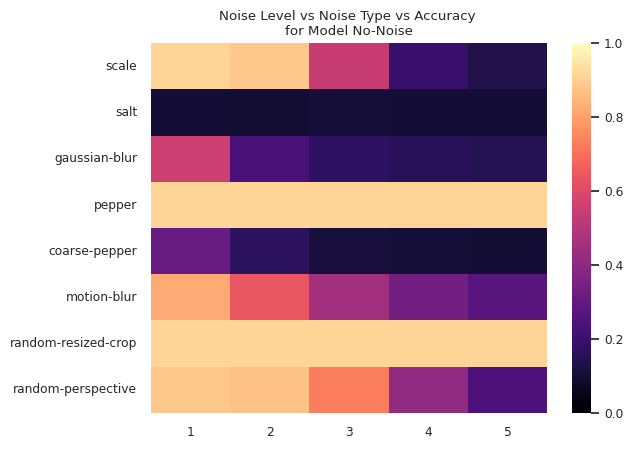

In [156]:
plot_heatmap_for_noise_trained_model(all_model_test_results =base_model_results['base_model.pth'], noise_type_trained_with='No-Noise')

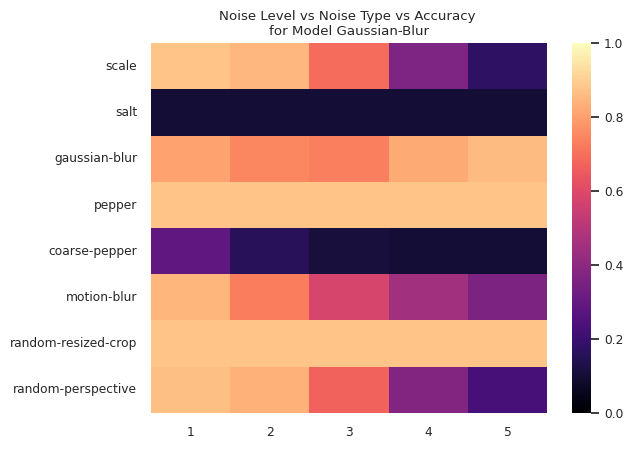

In [155]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_1_results['DoE1_model_1.pth'], noise_type_trained_with='Gaussian-Blur')

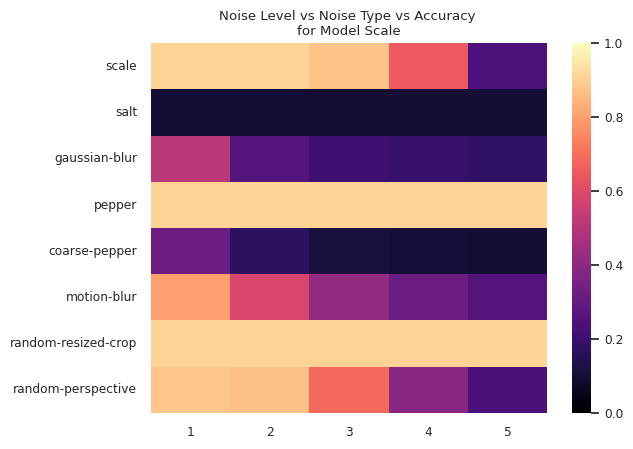

In [157]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_2_results['DoE1_model_2.pth'], noise_type_trained_with='Scale')

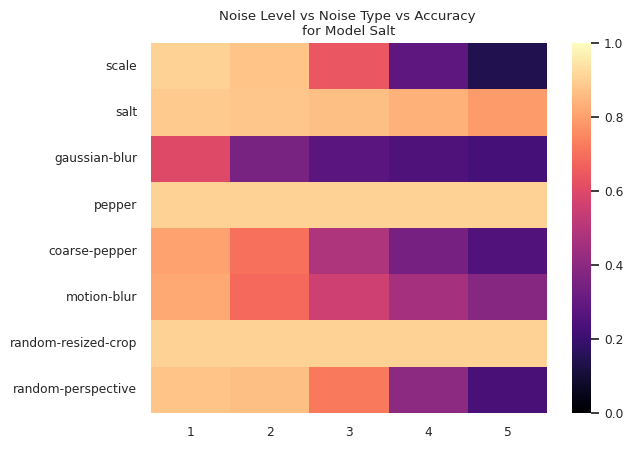

In [158]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_3_results['DoE1_model_3.pth'], noise_type_trained_with='Salt')

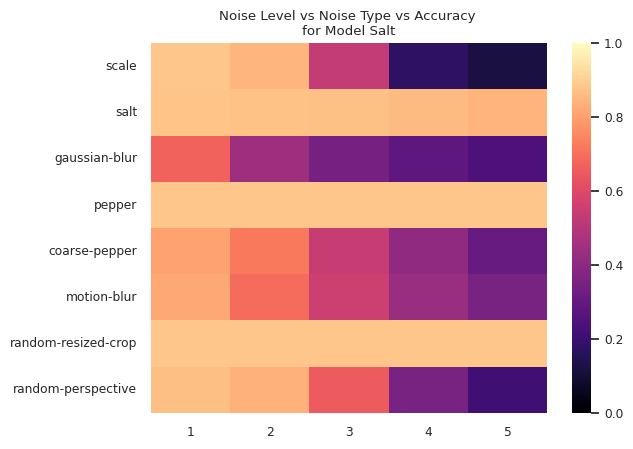

In [159]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_4_results['DoE1_model_4.pth'], noise_type_trained_with='Salt')

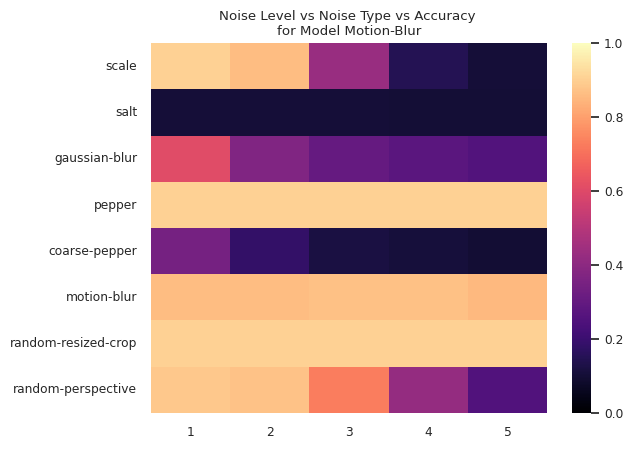

In [160]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_5_results['DoE1_model_5.pth'], noise_type_trained_with='Motion-Blur')

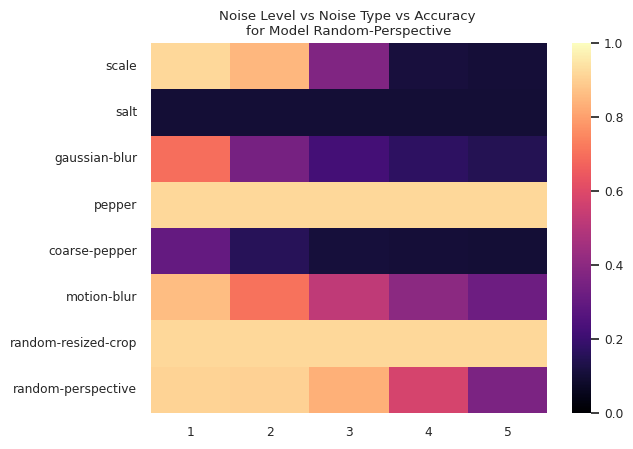

In [161]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_6_results['DoE1_model_6.pth'], noise_type_trained_with='Random-Perspective')

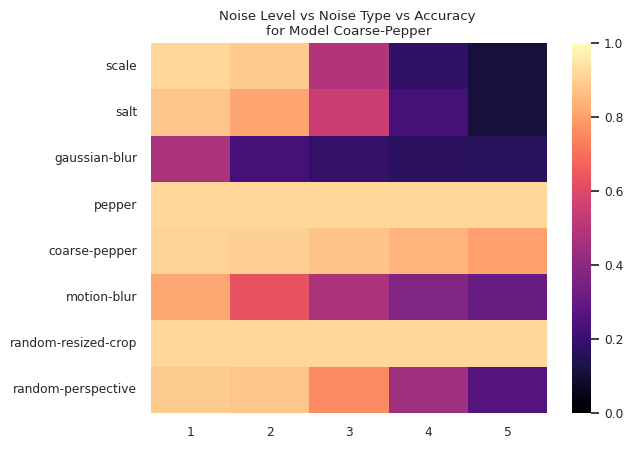

In [162]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_7_results['DoE1_model_7.pth'], noise_type_trained_with='Coarse-Pepper')

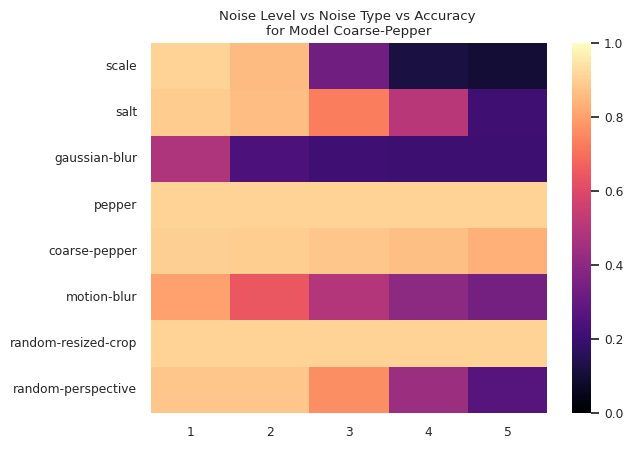

In [163]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_8_results['DoE1_model_8.pth'], noise_type_trained_with='Coarse-Pepper')

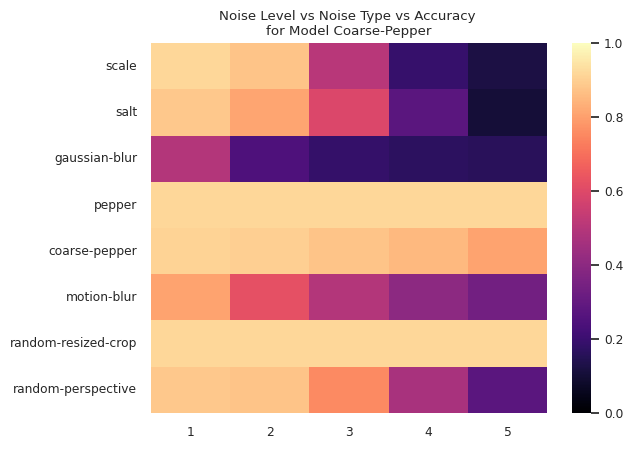

In [164]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_9_results['DoE1_model_9.pth'], noise_type_trained_with='Coarse-Pepper')

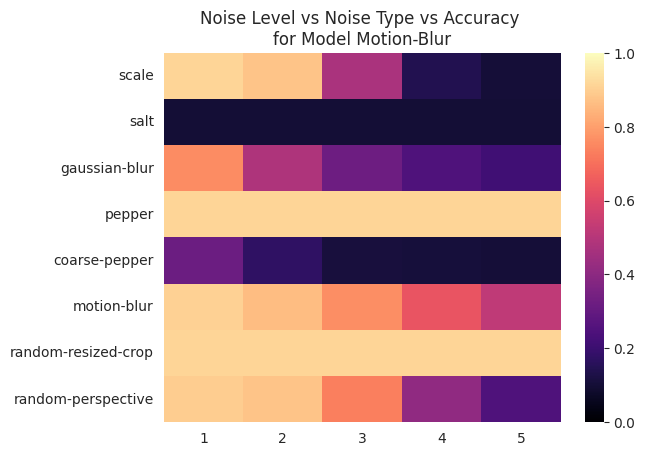

In [22]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_test_results['DoE1_model_10.pth'], noise_type_trained_with='Motion-Blur')                                                   # close the plot

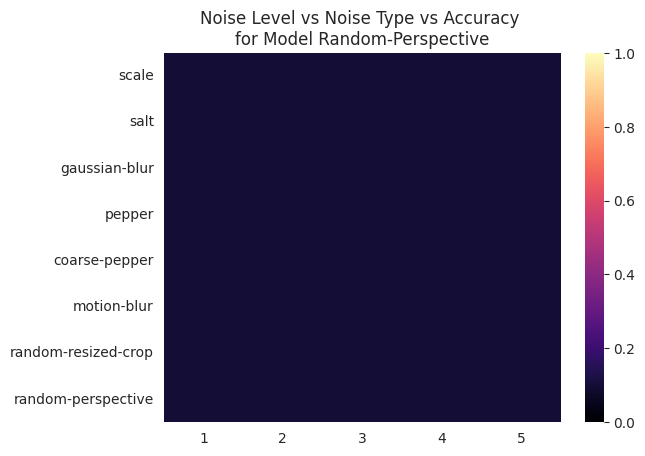

In [23]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_test_results['DoE1_model_11.pth'], noise_type_trained_with='Random-Perspective')                                              # close the plot

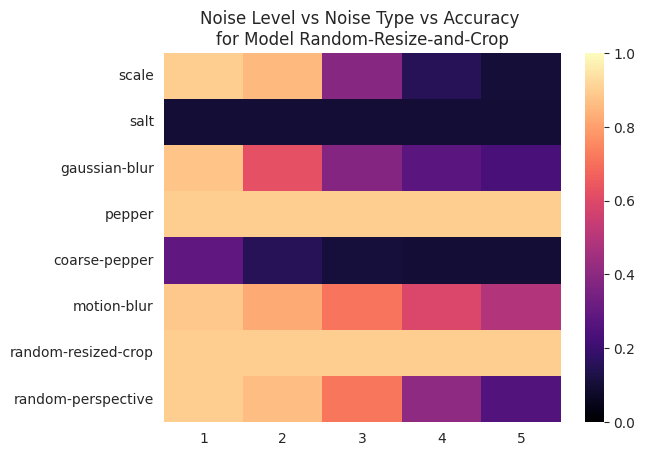

In [24]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_test_results['DoE1_model_12.pth'], noise_type_trained_with='Random-Resize-and-Crop')

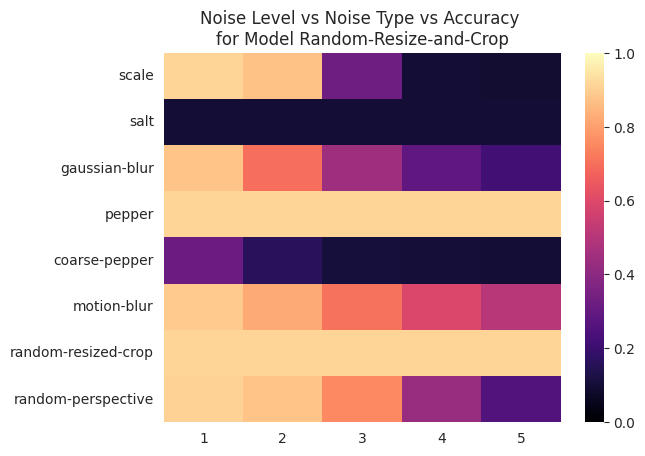

In [25]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_test_results['DoE1_model_13.pth'], noise_type_trained_with='Random-Resize-and-Crop')

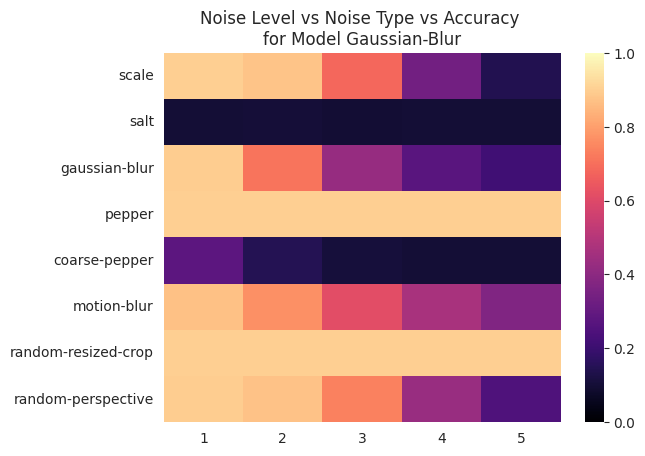

In [26]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_test_results['DoE1_model_14.pth'], noise_type_trained_with='Gaussian-Blur')

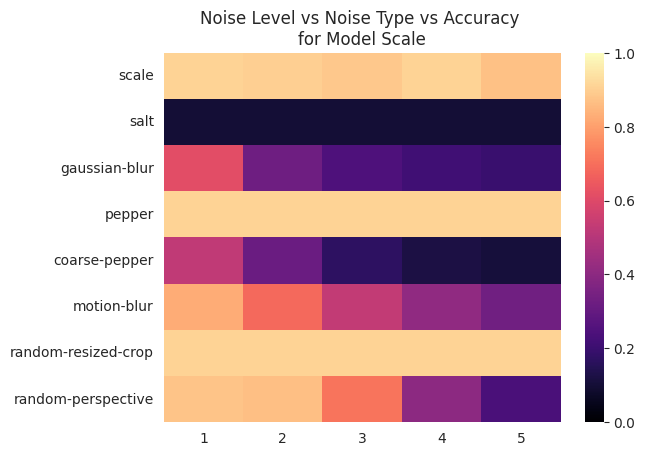

In [27]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_test_results['DoE1_model_15.pth'], noise_type_trained_with='Scale')

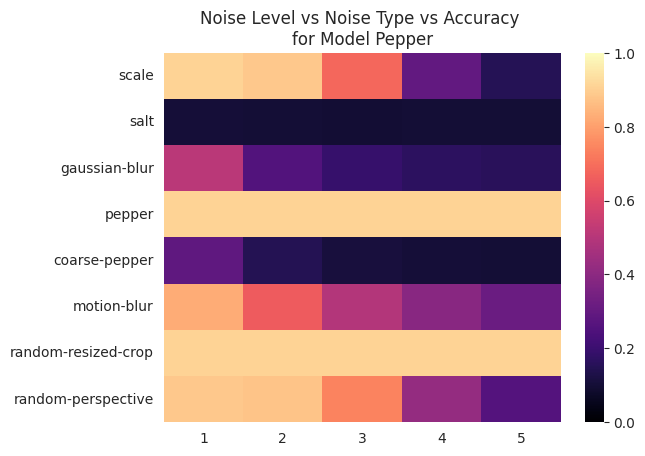

In [28]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_test_results['DoE1_model_16.pth'], noise_type_trained_with='Pepper')

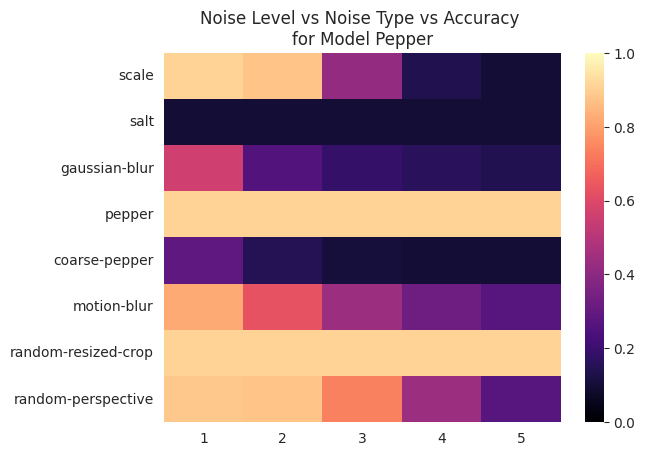

In [29]:
plot_heatmap_for_noise_trained_model(all_model_test_results =model_test_results['DoE1_model_17.pth'], noise_type_trained_with='Model 17 - Pepper Intensity 2, 30% ')

In [144]:
# notes: the all_model_test_results argument is ONE of the sub-dictionaries that comes out of the tripple for loop that calls test_function
def test_dataset_combiner(model_test_results, base_model_results, model_1_results, model_2_results, model_3_results, model_4_results, model_5_results, model_6_results, model_7_results, model_8_results, model_9_results):

    dfx_index = [f'M-0 (base_model): scale',
                 f'M-0 (base_model): salt',
                 f'M-0 (base_model): gaussian-blur',
                 f'M-0 (base_model): pepper',
                 f'M-0 (base_model): coarse-pepper',
                 f'M-0 (base_model): motion-blur',
                 f'M-0 (base_model): random-resized-crop',
                 f'M-0 (base_model): random-perspective']

    dfx1_index = [f'M-1 (G-Blur, 5, 80%): scale',
                 f'M-1 (G-Blur, 5, 80%): salt',
                 f'M-1 (G-Blur, 5, 80%): gaussian-blur',
                 f'M-1 (G-Blur, 5, 80%): pepper',
                 f'M-1 (G-Blur, 5, 80%): coarse-pepper',
                 f'M-1 (G-Blur, 5, 80%): motion-blur',
                 f'M-1 (G-Blur, 5, 80%): random-resized-crop',
                 f'M-1 (G-Blur, 5, 80%): random-perspective']

    dfx2_index = [f'M-2 (Scale, 3, 90%): scale',
                  f'M-2 (Scale, 3, 90%): salt',
                  f'M-2 (Scale, 3, 90%): gaussian-blur',
                  f'M-2 (Scale, 3, 90%): pepper',
                  f'M-2 (Scale, 3, 90%): coarse-pepper',
                  f'M-2 (Scale, 3, 90%): motion-blur',
                  f'M-2 (Scale, 3, 90%): random-resized-crop',
                  f'M-2 (Scale, 3, 90%): random-perspective']

    dfx3_index = [f'M-3 (Salt, 3, 20%): scale',
                  f'M-3 (Salt, 3, 20%): salt',
                  f'M-3 (Salt, 3, 20%): gaussian-blur',
                  f'M-3 (Salt, 3, 20%): pepper',
                  f'M-3 (Salt, 3, 20%): coarse-pepper',
                  f'M-3 (Salt, 3, 20%): motion-blur',
                  f'M-3 (Salt, 3, 20%): random-resized-crop',
                  f'M-3 (Salt, 3, 20%): random-perspective']

    dfx4_index = [f'M-4 (Salt, 4, 40%): scale',
                  f'M-4 (Salt, 4, 40%): salt',
                  f'M-4 (Salt, 4, 40%): gaussian-blur',
                  f'M-4 (Salt, 4, 40%): pepper',
                  f'M-4 (Salt, 4, 40%): coarse-pepper',
                  f'M-4 (Salt, 4, 40%): motion-blur',
                  f'M-4 (Salt, 4, 40%): random-resized-crop',
                  f'M-4 (Salt, 4, 40%): random-perspective']

    dfx5_index = [f'M-5 (M-Blur, 5, 50%): scale',
                  f'M-5 (M-Blur, 5, 50%): salt',
                  f'M-5 (M-Blur, 5, 50%): gaussian-blur',
                  f'M-5 (M-Blur, 5, 50%): pepper',
                  f'M-5 (M-Blur, 5, 50%): coarse-pepper',
                  f'M-5 (M-Blur, 5, 50%): motion-blur',
                  f'M-5 (M-Blur, 5, 50%): random-resized-crop',
                  f'M-5 (M-Blur, 5, 50%): random-perspective']

    dfx6_index = [f'M-6 (Rand-P, 2, 40%): scale',
                  f'M-6 (Rand-P, 2, 40%): salt',
                  f'M-6 (Rand-P, 2, 40%): gaussian-blur',
                  f'M-6 (Rand-P, 2, 40%): pepper',
                  f'M-6 (Rand-P, 2, 40%): coarse-pepper',
                  f'M-6 (Rand-P, 2, 40%): motion-blur',
                  f'M-6 (Rand-P, 2, 40%): random-resized-crop',
                  f'M-6 (Rand-P, 2, 40%): random-perspective']

    dfx7_index = [f'M-7 (C-Pepper, 2, 100%): scale',
                  f'M-7 (C-Pepper, 2, 100%): salt',
                  f'M-7 (C-Pepper, 2, 100%): gaussian-blur',
                  f'M-7 (C-Pepper, 2, 100%): pepper',
                  f'M-7 (C-Pepper, 2, 100%): coarse-pepper',
                  f'M-7 (C-Pepper, 2, 100%): motion-blur',
                  f'M-7 (C-Pepper, 2, 100%): random-resized-crop',
                  f'M-7 (C-Pepper, 2, 100%): random-perspective']

    dfx8_index = [f'M-8 (C-Pepper, 5, 80%): scale',
                  f'M-8 (C-Pepper, 5, 80%): salt',
                  f'M-8 (C-Pepper, 5, 80%): gaussian-blur',
                  f'M-8 (C-Pepper, 5, 80%): pepper',
                  f'M-8 (C-Pepper, 5, 80%): coarse-pepper',
                  f'M-8 (C-Pepper, 5, 80%): motion-blur',
                  f'M-8 (C-Pepper, 5, 80%): random-resized-crop',
                  f'M-8 (C-Pepper, 5, 80%): random-perspective']

    dfx9_index = [f'M-9 (C-Pepper, 3, 60%): scale',
                  f'M-9 (C-Pepper, 3, 60%): salt',
                  f'M-9 (C-Pepper, 3, 60%): gaussian-blur',
                  f'M-9 (C-Pepper, 3, 60%): pepper',
                  f'M-9 (C-Pepper, 3, 60%): coarse-pepper',
                  f'M-9 (C-Pepper, 3, 60%): motion-blur',
                  f'M-9 (C-Pepper, 3, 60%): random-resized-crop',
                  f'M-9 (C-Pepper, 3, 60%): random-perspective']

    dfx10_index= [f'M-10 (M-Blur, 1, 30%): scale',
                  f'M-10 (M-Blur, 1, 30%): salt',
                  f'M-10 (M-Blur, 1, 30%): gaussian-blur',
                  f'M-10 (M-Blur, 1, 30%): pepper',
                  f'M-10 (M-Blur, 1, 30%): coarse-pepper',
                  f'M-10 (M-Blur, 1, 30%): motion-blur',
                  f'M-10 (M-Blur, 1, 30%): random-resized-crop',
                  f'M-10 (M-Blur, 1, 30%): random-perspective']

    dfx11_index= [f'M-11 (Rand-P, 4, 20%): scale',
                  f'M-11 (Rand-P, 4, 20%): salt',
                  f'M-11 (Rand-P, 4, 20%): gaussian-blur',
                  f'M-11 (Rand-P, 4, 20%): pepper',
                  f'M-11 (Rand-P, 4, 20%): coarse-pepper',
                  f'M-11 (Rand-P, 4, 20%): motion-blur',
                  f'M-11 (Rand-P, 4, 20%): random-resized-crop',
                  f'M-11 (Rand-P, 4, 20%): random-perspective']

    dfx12_index= [f'M-12 (Rand-R&C, 3, 90%): scale',
                  f'M-12 (Rand-R&C, 3, 90%): salt',
                  f'M-12 (Rand-R&C, 3, 90%): gaussian-blur',
                  f'M-12 (Rand-R&C, 3, 90%): pepper',
                  f'M-12 (Rand-R&C, 3, 90%): coarse-pepper',
                  f'M-12 (Rand-R&C, 3, 90%): motion-blur',
                  f'M-12 (Rand-R&C, 3, 90%): random-resized-crop',
                  f'M-12 (Rand-R&C, 3, 90%): random-perspective']

    dfx13_index= [f'M-13 (Rand-R&C, 3, 70%): scale',
                  f'M-13 (Rand-R&C, 3, 70%): salt',
                  f'M-13 (Rand-R&C, 3, 70%): gaussian-blur',
                  f'M-13 (Rand-R&C, 3, 70%): pepper',
                  f'M-13 (Rand-R&C, 3, 70%): coarse-pepper',
                  f'M-13 (Rand-R&C, 3, 70%): motion-blur',
                  f'M-13 (Rand-R&C, 3, 70%): random-resized-crop',
                  f'M-13 (Rand-R&C, 3, 70%): random-perspective']

    dfx14_index= [f'M-14 (G-B, 1, 60%): scale',
                  f'M-14 (G-B, 1, 60%): salt',
                  f'M-14 (G-B, 1, 60%): gaussian-blur',
                  f'M-14 (G-B, 1, 60%): pepper',
                  f'M-14 (G-B, 1, 60%): coarse-pepper',
                  f'M-14 (G-B, 1, 60%): motion-blur',
                  f'M-14 (G-B, 1, 60%): random-resized-crop',
                  f'M-14 (G-B, 1, 60%): random-perspective']

    dfx15_index= [f'M-15 (Scale, 4, 70%): scale',
                  f'M-15 (Scale, 4, 70%): salt',
                  f'M-15 (Scale, 4, 70%): gaussian-blur',
                  f'M-15 (Scale, 4, 70%): pepper',
                  f'M-15 (Scale, 4, 70%): coarse-pepper',
                  f'M-15 (Scale, 4, 70%): motion-blur',
                  f'M-15 (Scale, 4, 70%): random-resized-crop',
                  f'M-15 (Scale, 4, 70%): random-perspective']

    dfx16_index= [f'M-16 (Pepper, 4, 10%): scale',
                  f'M-16 (Pepper, 4, 10%): salt',
                  f'M-16 (Pepper, 4, 10%): gaussian-blur',
                  f'M-16 (Pepper, 4, 10%): pepper',
                  f'M-16 (Pepper, 4, 10%): coarse-pepper',
                  f'M-16 (Pepper, 4, 10%): motion-blur',
                  f'M-16 (Pepper, 4, 10%): random-resized-crop',
                  f'M-16 (Pepper, 4, 10%): random-perspective']

    dfx17_index= [f'M-17 (Pepper, 2, 30%): scale',
                  f'M-17 (Pepper, 2, 30%): salt',
                  f'M-17 (Pepper, 2, 30%): gaussian-blur',
                  f'M-17 (Pepper, 2, 30%): pepper',
                  f'M-17 (Pepper, 2, 30%): coarse-pepper',
                  f'M-17 (Pepper, 2, 30%): motion-blur',
                  f'M-17 (Pepper, 2, 30%): random-resized-crop',
                  f'M-17 (Pepper, 2, 30%): random-perspective']

    dfx = pd.DataFrame.from_dict(data=base_model_results["base_model.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx.index = dfx_index
    dfx.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx.insert(6, "Modle_Noise_Type",      ["no-noise"]*8, True)
    dfx.insert(7, "Modle_Noise_Intensity", [0]*8, True)
    dfx.insert(8, "App_freq",              [0.0]*8, True)
    dfx.insert(9, "order", [0]*8, True)


    dfx1 = pd.DataFrame.from_dict(data=model_1_results["DoE1_model_1.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx1.index = dfx1_index
    dfx1.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx1.insert(6, "Modle_Noise_Type",      ["gaussian-blur"]*8, True)
    dfx1.insert(7, "Modle_Noise_Intensity", [5]*8, True)
    dfx1.insert(8, "App_freq",              [0.8]*8, True)
    dfx1.insert(9, "order", [1]*8, True)
    dfx = pd.concat([dfx, dfx1], ignore_index=False)

    dfx2 = pd.DataFrame.from_dict(data=model_2_results["DoE1_model_2.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx2.index = dfx2_index
    dfx2.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx2.insert(6, "Modle_Noise_Type",      ["scale"]*8, True)
    dfx2.insert(7, "Modle_Noise_Intensity", [2]*8, True)
    dfx2.insert(8, "App_freq",              [0.9]*8, True)
    dfx2.insert(9, "order", [2]*8, True)
    dfx = pd.concat([dfx, dfx2], ignore_index=False)

    dfx3 = pd.DataFrame.from_dict(data=model_3_results["DoE1_model_3.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx3.index = dfx3_index
    dfx3.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx3.insert(6, "Modle_Noise_Type",      ["salt"]*8, True)
    dfx3.insert(7, "Modle_Noise_Intensity", [3]*8, True)
    dfx3.insert(8, "App_freq",              [0.2]*8, True)
    dfx3.insert(9, "order", [3]*8, True)
    dfx = pd.concat([dfx, dfx3], ignore_index=False)

    dfx4 = pd.DataFrame.from_dict(data=model_4_results["DoE1_model_4.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx4.index = dfx4_index
    dfx4.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx4.insert(6, "Modle_Noise_Type",      ["salt"]*8, True)
    dfx4.insert(7, "Modle_Noise_Intensity", [4]*8, True)
    dfx4.insert(8, "App_freq",              [0.4]*8, True)
    dfx4.insert(9, "order", [4]*8, True)
    dfx = pd.concat([dfx, dfx4], ignore_index=False)

    dfx5 = pd.DataFrame.from_dict(data=model_5_results["DoE1_model_5.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx5.index = dfx5_index
    dfx5.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx5.insert(6, "Modle_Noise_Type",      ["motion-blur"]*8, True)
    dfx5.insert(7, "Modle_Noise_Intensity", [5]*8, True)
    dfx5.insert(8, "App_freq",              [0.5]*8, True)
    dfx5.insert(9, "order", [5]*8, True)
    dfx = pd.concat([dfx, dfx5], ignore_index=False)

    dfx6 = pd.DataFrame.from_dict(data=model_6_results["DoE1_model_6.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx6.index = dfx6_index
    dfx6.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx6.insert(6, "Modle_Noise_Type",      ["random-perspective"]*8, True)
    dfx6.insert(7, "Modle_Noise_Intensity", [2]*8, True)
    dfx6.insert(8, "App_freq",              [0.4]*8, True)
    dfx6.insert(9, "order", [6]*8, True)
    dfx = pd.concat([dfx, dfx6], ignore_index=False)

    dfx7 = pd.DataFrame.from_dict(data=model_7_results["DoE1_model_7.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx7.index = dfx7_index
    dfx7.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx7.insert(6, "Modle_Noise_Type",      ["coarse-pepper"]*8, True)
    dfx7.insert(7, "Modle_Noise_Intensity", [2]*8, True)
    dfx7.insert(8, "App_freq",              [1.0]*8, True)
    dfx7.insert(9, "order", [7]*8, True)
    dfx = pd.concat([dfx, dfx7], ignore_index=False)

    dfx8 = pd.DataFrame.from_dict(data=model_8_results["DoE1_model_8.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx8.index = dfx8_index
    dfx8.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx8.insert(6, "Modle_Noise_Type",      ["coarse-pepper"]*8, True)
    dfx8.insert(7, "Modle_Noise_Intensity", [5]*8, True)
    dfx8.insert(8, "App_freq",              [0.8]*8, True)
    dfx8.insert(9, "order", [8]*8, True)
    dfx = pd.concat([dfx, dfx8], ignore_index=False)

    dfx9 = pd.DataFrame.from_dict(data=model_9_results["DoE1_model_9.pth"], orient='index', columns=["1", "2", "3", "4", "5"])
    dfx9.index = dfx9_index
    dfx9.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
    dfx9.insert(6, "Modle_Noise_Type",      ["coarse-pepper"]*8, True)
    dfx9.insert(7, "Modle_Noise_Intensity", [3]*8, True)
    dfx9.insert(8, "App_freq",              [0.6]*8, True)
    dfx9.insert(9, "order", [9]*8, True)
    dfx = pd.concat([dfx, dfx9], ignore_index=False)

    i = 10
    for model in model_test_results:
        model_results = model_test_results[model]
        df = pd.DataFrame.from_dict(data=model_results, orient='index', columns=["1", "2", "3", "4", "5"])
        if i == 10:
            df.index = dfx10_index
            df.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
            df.insert(6, "Modle_Noise_Type",      ["motion-blur"]*8, True)
            df.insert(7, "Modle_Noise_Intensity", [1]*8, True)
            df.insert(8, "App_freq",              [0.3]*8, True)
            df.insert(9, "order", [10]*8, True)
        elif i == 11:
            df.index = dfx11_index
            df.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
            df.insert(6, "Modle_Noise_Type",      ["random-perspective"]*8, True)
            df.insert(7, "Modle_Noise_Intensity", [4]*8, True)
            df.insert(8, "App_freq",              [0.2]*8, True)
            df.insert(9, "order", [11]*8, True)
        elif i == 12:
            df.index = dfx12_index
            df.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
            df.insert(6, "Modle_Noise_Type",      ["random-resize-and-crop"]*8, True)
            df.insert(7, "Modle_Noise_Intensity", [3]*8, True)
            df.insert(8, "App_freq",              [0.9]*8, True)
            df.insert(9, "order", [12]*8, True)
        elif i == 13:
            df.index = dfx13_index
            df.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
            df.insert(6, "Modle_Noise_Type",      ["random-resize-and-crop"]*8, True)
            df.insert(7, "Modle_Noise_Intensity", [3]*8, True)
            df.insert(8, "App_freq",              [0.7]*8, True)
            df.insert(9, "order", [13]*8, True)
        elif i == 14:
            df.index = dfx14_index
            df.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
            df.insert(6, "Modle_Noise_Type",      ["gaussian-blur"]*8, True)
            df.insert(7, "Modle_Noise_Intensity", [1]*8, True)
            df.insert(8, "App_freq",              [0.6]*8, True)
            df.insert(9, "order", [14]*8, True)
        elif i == 15:
            df.index = dfx15_index
            df.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
            df.insert(6, "Modle_Noise_Type",      ["scale"]*8, True)
            df.insert(7, "Modle_Noise_Intensity", [4]*8, True)
            df.insert(8, "App_freq",              [0.7]*8, True)
            df.insert(9, "order", [15]*8, True)
        elif i == 16:
            df.index = dfx16_index
            df.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
            df.insert(6, "Modle_Noise_Type",      ["pepper"]*8, True)
            df.insert(7, "Modle_Noise_Intensity", [4]*8, True)
            df.insert(8, "App_freq",              [0.1]*8, True)
            df.insert(9, "order", [16]*8, True)
        elif i == 17:
            df.index = dfx17_index
            df.insert(5, "Test_noise_Type",       ["scale", "salt", "gaussian-blur", "pepper", "coarse-pepper", "motion-blur", "random-resized-crop", "random-perspective"], True)
            df.insert(6, "Modle_Noise_Type",      ["pepper"]*8, True)
            df.insert(7, "Modle_Noise_Intensity", [2]*8, True)
            df.insert(8, "App_freq",              [0.3]*8, True)
            df.insert(9, "order", [17]*8, True)

        i = i + 1
        dfx = pd.concat([dfx, df], ignore_index=False)

    return dfx

In [145]:
dfx = test_dataset_combiner(model_test_results, base_model_results, model_1_results, model_2_results, model_3_results, model_4_results, model_5_results, model_6_results, model_7_results, model_8_results, model_9_results)
dfx.to_csv("test_data.csv")

In [146]:
dfx

,1,2,3,4,5,Test_noise_Type,Modle_Noise_Type,Modle_Noise_Intensity,App_freq,order
M-0 (base_model): scale,0.9122,0.8834,0.5417,0.1933,0.1337,scale,no-noise,0,0.0,0
M-0 (base_model): salt,0.1004,0.0971,0.1019,0.0991,0.1009,salt,no-noise,0,0.0,0
M-0 (base_model): gaussian-blur,0.5531,0.2346,0.1735,0.1569,0.1521,gaussian-blur,no-noise,0,0.0,0
M-0 (base_model): pepper,0.9122,0.9122,0.9122,0.9122,0.9122,pepper,no-noise,0,0.0,0
M-0 (base_model): coarse-pepper,0.3093,0.1666,0.1104,0.1022,0.1007,coarse-pepper,no-noise,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
"M-17 (Pepper, 2, 30%): pepper",0.9086,0.9086,0.9086,0.9086,0.9086,pepper,pepper,2,0.3,17
"M-17 (Pepper, 2, 30%): coarse-pepper",0.2870,0.1495,0.1073,0.1013,0.1000,coarse-pepper,pepper,2,0.3,17
"M-17 (Pepper, 2, 30%): motion-blur",0.8233,0.6283,0.4404,0.3280,0.2691,motion-blur,pepper,2,0.3,17
"M-17 (Pepper, 2, 30%): random-resized-crop",0.9086,0.9086,0.9086,0.9086,0.9086,random-resized-crop,pepper,2,0.3,17


In [167]:
def plot_heatmap_for_all_noise(dfx ):
    '''
    This plot constructs a single heatmap that plots all of the test accuracy results for ONE model. That model should have been
    tested against several different test data sets. Each individual test data set should contain normal data, and data from ONE
    adversarial noise type at ONE intensity setting. This means for each adversarial noise type will we test each model 5 times,
    and get five different accuracy results. Therefore, if we have 3 different adversarial noises, we test each model 15 times.

    all_model_test_results (dict): a dictionary of lists containing the results of a tests for this specific model. Organized like so:
            all_model_test_results = {
                                         "adversarial_noise_1_results": [float_accuracy_1, float_accuracy_2, float_accuracy_3, float_accuracy_4, float_accuracy_5],
                                         "adversarial_noise_2_results": [float_accuracy_1, float_accuracy_2, float_accuracy_3, float_accuracy_4, float_accuracy_5],
                                         "adversarial_noise_3_results": [float_accuracy_1, float_accuracy_2, float_accuracy_3, float_accuracy_4, float_accuracy_5]
                                       }

    noise_type_trained_with (str): the name of the model that was tested
    '''

    fig = plt.figure(figsize=(3,30))

    sb.set(font_scale=0.8)

    dfx = dfx.sort_values(by=["Test_noise_Type", "order"], ascending=[True, True], na_position='first')
    #dfx = dfx.drop(labels=["Test_noise_Type", "Modle_Noise_Type", "Modle_Noise_Intensity", "App_freq"], axis=1)
    sb.heatmap(data=dfx[["1", "2", "3", "4", "5"]], vmin = 0.0, vmax = 1.0, cmap="magma", square=False, cbar_kws = dict(use_gridspec=True,location="top"))

    # ADD CODE HERE to produce a heatmap
    # x-axis: noise level of the TEST data
    # y-axis: noise type *tested* against (i.e. what kind of noise was injected in to the TEST data)
    # color: final test accuracy of the model

    # Look at Seaborne documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html
    # Suggested color palette is magma, it produces clearly understandable results

    plt.title(f"Noise Level vs Noise Type vs Accuracy") # Add a title
    plt.show()                                                                                # show the plot
    plt.close()

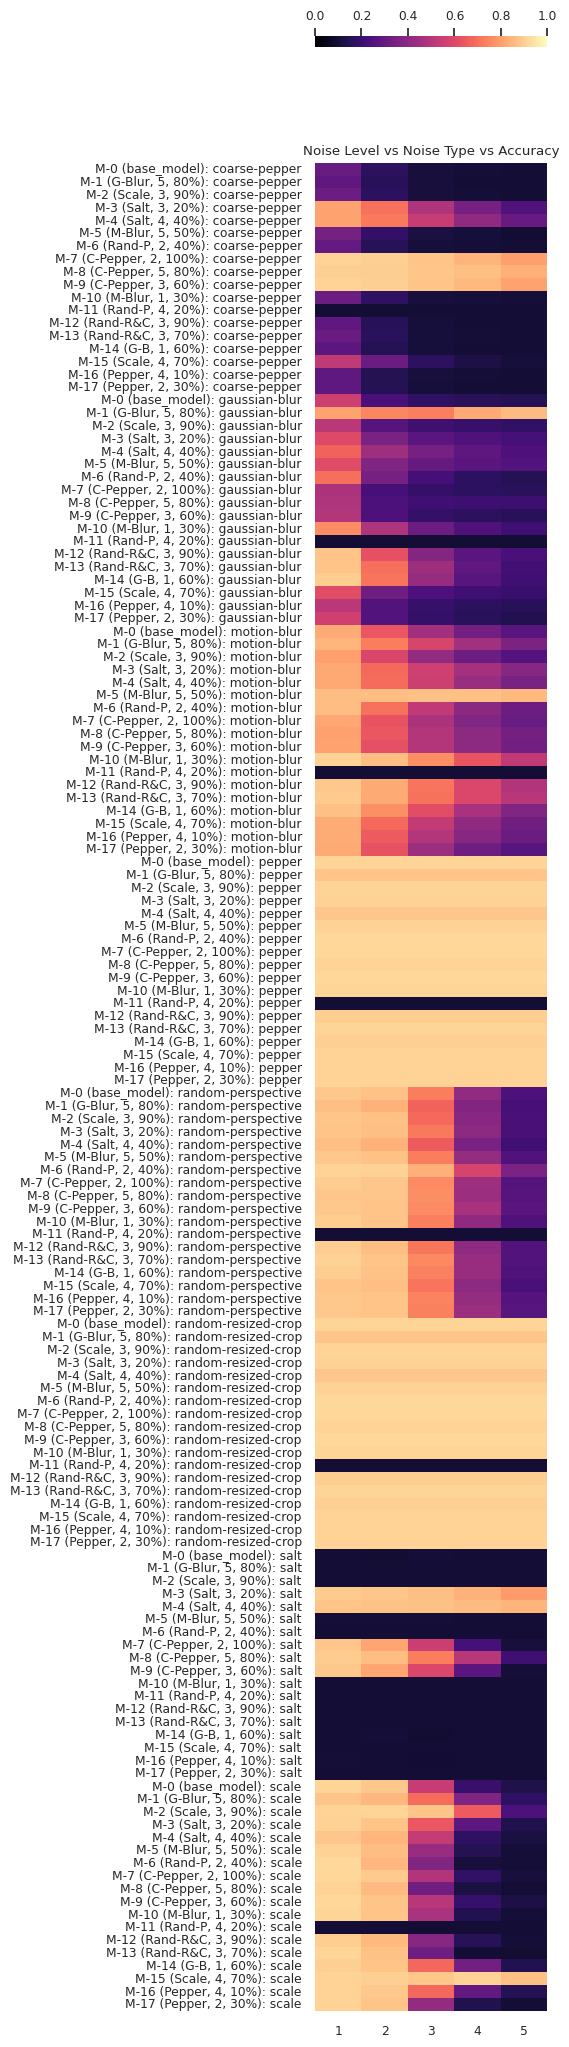

In [168]:
plot_heatmap_for_all_noise(dfx)

In [116]:

def plot_accuracy_linegraph_for_noise_trained_model_against_multiple_adversarial_noise(all_model_test_restults: dict, noise_type_trained_with: str = "MODEL_NAME", legend_location:str="lower left"):
    if noise_type_trained_with == "MODEL_NAME":
        raise ValueError("Please supply the name of the model that these results come from.")

    for noise_type in all_model_test_restults:
        plt.plot([1, 2, 3, 4, 5], noise_type)                                      # plot the test accuracy of the model against increase noise intensity levels

    plt.legend(loc="lower left", labels=list(all_model_test_restults.keys()))
    plt.ylim((0.0, 1.0))                                                        # ensure Y-Axis streches from 0.0 to 1.0
    plt.title(f"Accuracy vs Noise Level \nfor Model {noise_type_trained_with}") # Add a title
    plt.show()                                                                  # show the plot
    plt.close()                                                                 # close the plot

In [31]:
plot_accuracy_linegraph_for_noise_trained_model_against_multiple_adversarial_noise(all_model_test_restults=model_test_results['DoE1_model_17.pth'], noise_type_trained_with="pepper, legend_location="lower left")

SyntaxError: invalid syntax (3768431784.py, line 1)

scale
salt
gaussian-blur
pepper
coarse-pepper
motion-blur
random-resized-crop
random-perspective


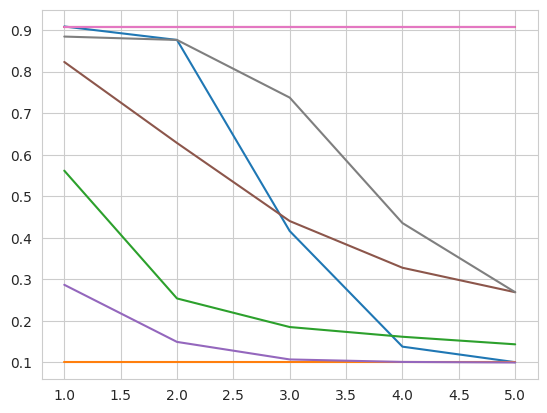

In [35]:
for noise_type in model_test_results['DoE1_model_17.pth']:
    print(noise_type)
    plt.plot([1, 2, 3, 4, 5], model_test_results['DoE1_model_17.pth'][noise_type])

# plt.legend(loc="lower left", labels=list(model_test_results['DoE1_model_17.pth'].keys()))
# plt.ylim((0.0, 1.0))                                                        # ensure Y-Axis streches from 0.0 to 1.0
# plt.show()                                                                  # show the plot
# plt.close()